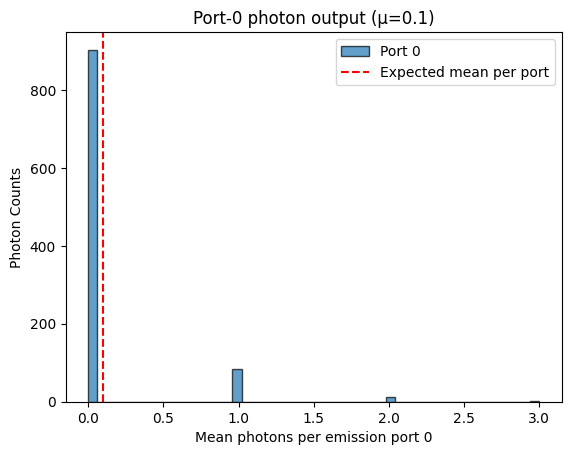

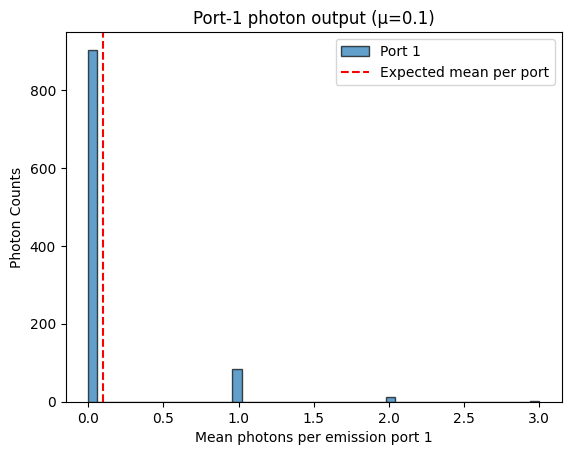


Expected mean per port: 0.100
Port 0: 0.110 ± 0.355
Port 1: 0.110 ± 0.355

Expected total: 0.200
Total: 0.220 ± 0.710


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sequence.kernel.timeline import Timeline
from sequence.components.spdc_source_node import SpdcSourceNode
from numpy import random
from sequence.utils.encoding import polarization



def test_source_node_emission(mean_photon_num=0.5, num_pulses=1, trials=1, bell_state="psi+"):
    port0_means = []
    port1_means = []
    total_means = []

    class DummyReceiver:
        def __init__(self):
            self.count = 0
        def get(self, photon, **kwargs):
            self.count += 1

    for _ in range(trials):
        timeline = Timeline()
        timeline.seed = 0  # Vary randomness
        timeline.quantum_manager.truncation = 2

        config = {
            'wavelengths': [1550, 1550],
            'frequency': '1e6',
            'mean_photon_num': str(mean_photon_num),
            'phase_error': '0.0',
            'bandwidth': '0',
            'encoding': polarization,
            'bell_state': bell_state
            }

        node = SpdcSourceNode("source", timeline, config)

        # Replace ports with dummy photon counters
        spy0 = DummyReceiver()
        spy1 = DummyReceiver()
        node.ports[0]._receivers[0] = spy0
        node.ports[1]._receivers[0] = spy1
        
        node.spdc.emit(num_pulses = num_pulses)
        timeline.run()

        mean_port0 = spy0.count / num_pulses
        mean_port1 = spy1.count / num_pulses
        port0_means.append(mean_port0)
        port1_means.append(mean_port1)
        total_means.append(mean_port0 + mean_port1)

    # Plot per-port means for port 0
    plt.hist(port0_means, bins=50, alpha=0.7, label='Port 0', edgecolor='black')
    plt.axvline(mean_photon_num, color='red', linestyle='--', label='Expected mean per port')
    plt.xlabel('Mean photons per emission port 0')
    plt.ylabel('Photon Counts')
    plt.title(f'Port-0 photon output (μ={mean_photon_num})')
    plt.legend()
    plt.show()
    # Plot per-port means for port 1
    plt.hist(port1_means, bins=50, alpha=0.7, label='Port 1', edgecolor='black')
    plt.axvline(mean_photon_num, color='red', linestyle='--', label='Expected mean per port')
    plt.xlabel('Mean photons per emission port 1')
    plt.ylabel('Photon Counts')
    plt.title(f'Port-1 photon output (μ={mean_photon_num})')
    plt.legend()
    plt.show()
    # Print stats
    print(f"\nExpected mean per port: {mean_photon_num:.3f}")
    print(f"Port 0: {np.mean(port0_means):.3f} ± {np.std(port0_means):.3f}")
    print(f"Port 1: {np.mean(port1_means):.3f} ± {np.std(port1_means):.3f}")
    print(f"\nExpected total: {mean_photon_num * 2:.3f}")
    print(f"Total: {np.mean(total_means):.3f} ± {np.std(total_means):.3f}")

# Example run
test_source_node_emission(mean_photon_num=.1, num_pulses=1, trials=1000, bell_state="psi+")